<a href="https://colab.research.google.com/github/vihaannnn/AI-Allignment-Research/blob/master/Submissions/Week%205/Lime_Explanation_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Lime with Pytorch Resnet34 with pre trained - IMAGENET1K_V1 weights

This notebook aims to show the differences in what pixels are important for the resnet34 , resnet50 , and inception v3 model - detected by LIME
Parts of this notebook were genereated with the help of Perplexity AI
The notebooks that were taken for inspiration were - https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
and  Dr. Bent's in class XAI notebooks

In [52]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Here we want to load our image to see how it looks


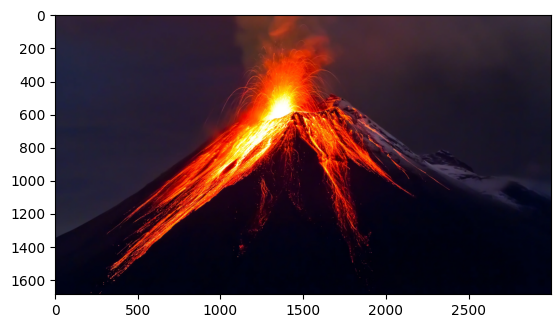

In [53]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image('volcano.png')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [54]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transformation = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transformation

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet34 available in Pytorch with pretrained weights

In [55]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Load label texts for ImageNet predictions so we know what model is predicting

In [56]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

Get the predicition for our image.

In [57]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [58]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.99998283, 980, 'volcano'),
 (1.38180985e-05, 862, 'torch'),
 (9.547572e-07, 644, 'matchstick'),
 (8.301112e-07, 556, 'fire_screen'),
 (5.0251697e-07, 827, 'stove'))

In [59]:
def transforming_pil():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def image_preprocess():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

transform_pil = transforming_pil()
preprocess_transform = image_preprocess()

In [60]:
import tensorflow as tf
def classify_images(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    # batch = torch.stack(tuple(preprocess_input(i) for i in images), dim=0)

    device = torch.device("cuda" if tf.test.gpu_device_name() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [61]:
test_pred = classify_images([transform_pil(img)])
test_pred.squeeze().argmax()

980

In [62]:
!pip install lime

Import lime and create explanation for this prediciton.

In [63]:
from lime import lime_image

# Doing the implimentation for Resnet 34

In [64]:
#make sure you are using a GPU to execute this
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(transform_pil(img)),
                                         classify_images, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # This is the number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Here we will print areas of the image that are encouraging the top prediction in our case a volcano

In [65]:
from skimage.segmentation import mark_boundaries

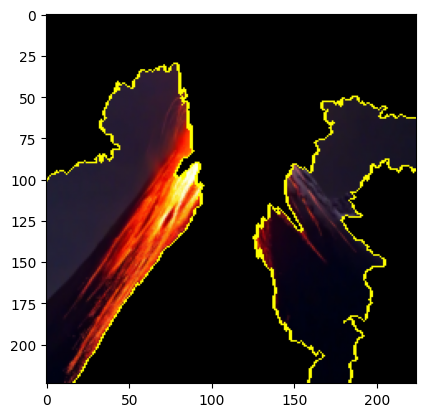

In [66]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True, min_weight=0)
img_with_boundary = mark_boundaries(temp/255.0, mask)
plt.imshow(img_with_boundary)

Here we are highlighting the areas of the image that are promoting a wrong predictions.

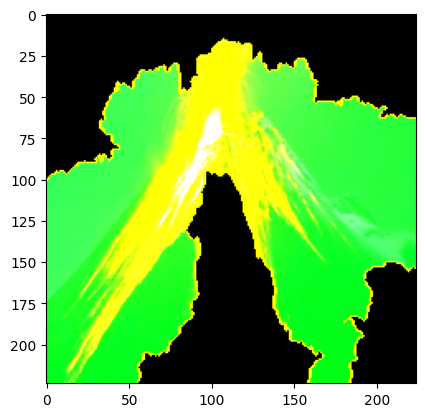

In [67]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_with_boundary_filled = mark_boundaries(temp/155.0, mask)
plt.imshow(img_with_boundary_filled)

# Doing the implimentation for Inception V3

In [68]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from torchvision import models


In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.inception_v3(pretrained=True)
model = model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [70]:
inception_volcano = preprocess_input(np.array(img))

In [71]:

explanation = explainer.explain_instance(np.array(transform_pil(img)), classify_images, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Here we will print areas of the image that are encouraging the top prediction in our case a volcano

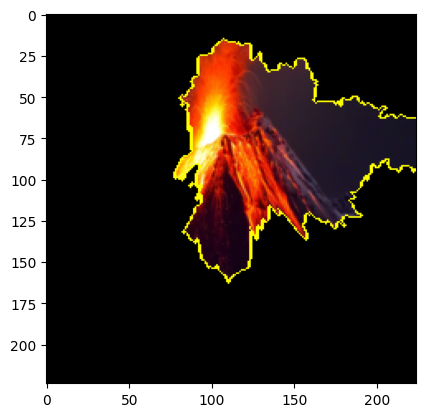

In [72]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True, min_weight=0)
img_with_boundary = mark_boundaries(temp/255.0, mask)
plt.imshow(img_with_boundary)

Here we are highlighting the areas of the image that are promoting a wrong predictions.

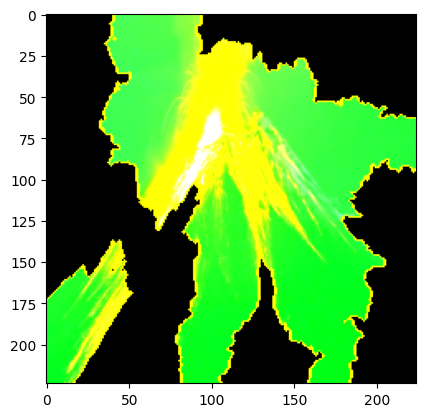

In [73]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_with_boundary_filled = mark_boundaries(temp/155.0, mask)
plt.imshow(img_with_boundary_filled)

# Doing the implimentation for Resnet 50

In [74]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [75]:
explanation = explainer.explain_instance(np.array(transform_pil(img)), classify_images, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Here we will print areas of the image that are encouraging the top prediction in our case a volcano

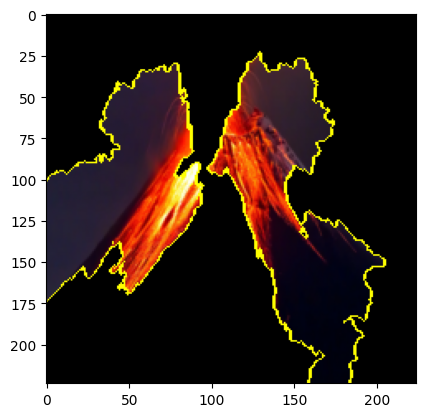

In [76]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True, min_weight=0)
img_with_boundary = mark_boundaries(temp/255.0, mask)
plt.imshow(img_with_boundary)

Here we are highlighting the areas of the image that are promoting a wrong predictions.

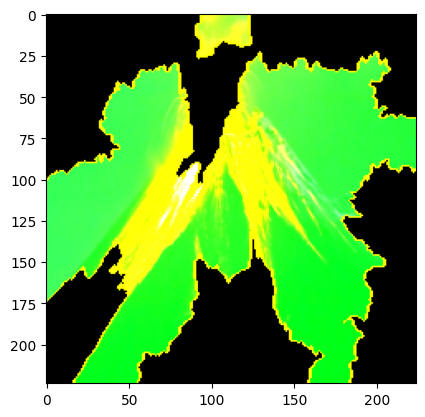

In [77]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_with_boundary_filled = mark_boundaries(temp/155.0, mask)
plt.imshow(img_with_boundary_filled)

# Why Lime

Lime is a super easy to use and lightweight application that can run on any model (model - agnostic) so it really allows for alot of flexibility. I chose lime as I am new to the field of Explainable ML so a basic implementation seemed better than using something far more complex.

# Strengths of LIME
1. Model agnostic
2. Explains individual predictions -> easy to use for understand what is happenning for a specific instance

Weaknesses of LIME
1. Since it perturbs the dataset - and generates perturbed images to predict -> the accuracies may sometimes not be that great
2. Can be easily fooled
3. Not great for higher order data
4. Explanations are not always consistant
